# Taming Model Behavior with Regularization   

### Steve Elston

## Introduction  

**Overfitting** is a constant danger with machine learning models. Overfit models fit the training data well. However, an overfit model will not **generalize**. A model that generalizes is a model which exhibits good performance on data cases beyond the ones used in training. Models that generalize will be useful in production. 

As a general rule, an overfit model has learned the training data too well. The overfitting likely involved learning noise present in the training data. The noise in the data is random and uninformative. When a new data case is presented to such a model it may produce unexpected results since the random noise will be different. 

So, what is one to do to prevent overfitting of machine learning models? The most widely used set of tools for preventing overfitting are known as **regularization methods**. Regularization methods take a number of forms, but all have the same goal, to prevent overfitting of machine learning models. 

Regularization is not free however. While regularization reduces the **variance** in the model results, it introduces **bias**. Whereas, an overfit model exhibits low bias the variance is high. The high variance leads to unpredictable results when the model is exposed to new data cases. On the other hand, the stronger the regularization of a model the lower the variance, but the greater the bias. This all means that when applying regularization you will need to contend with the **bias-variance trade-off**. 

To better understand the bias variance trade-off consider the following examples of extreme model cases:

- If the prediction for all cases is just the mean (or median), variance is minimized. The estimate for all cases is the same, so the bias of the estimates is zero. However, there is likely considerable variance in these estimates. 
- On the other hand, consider what happens when the data are fit with a kNN model with k=1. The training data will fit this model perfectly, since there is one model coefficient per training data point. The variance will be low. However, the model will have considerable bias when applied to test data. 

In either case, these extreme models will not generalize well and will exhibit large errors on any independent test data. Any practical model must come to terms with the trade-off between bias and variance to make accurate predictions. 

To better understand this trade-off you can consider the example of the mean square error, which can be decomposed into its components. The mean square error can be written as:

$$\Delta x = E \Big[ \big(Y - \hat{f}(X) \big)^2 \Big] = \frac{1}{N} \sum_{i=1}^N \big(y_i - \hat{f}(x_i) \big)^2 $$

Where,
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Expanding the representation of the mean square error:

$$\Delta x = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta x = Bias^2 + Variance + Irreducible\ Error$$

The relationship between bias and variance is illustrated in the figure below.

<img src="../images/BiasVariance.png" alt="Drawing" style="width:600px; height:400px"/>
<center> Trade-off between bias and variance for machine learning model <center>      
    

Study this relationship. Notice that as regularization reduces variance, bias increases. The irreducible error will remain unchanged. Regularization parameters are chosen to minimize $\Delta x$. In many cases, this will prove challenging. 

## Load and Split the Dataset

With the above bit of theory in mind, it is time to try an example. In this example you will compute and compare linear regression models using different levels and types of regularization. 

Execute the code in the cell below to load the packages required for the rest of this notebook.

In [2]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.api as sm
import statsmodels.formula.api as smf  
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import sklearn.metrics as sklm
from patsy import dmatrices
from math import sqrt

%matplotlib inline

The code below does the following to load and prepare the data set:    
1. Load the data set.   
2. Scale the numeric columns except the columns used as labels for the examples. 
3. Split the 195 cases into 100 training cases and 95 test cases.   

In [3]:
## Load the data frame   
auto_data = pd.read_csv('../data/AutoPricesClean.csv')

## Remove unwanted columns and normalize numeric features   
auto_data.drop(auto_data.columns[:3], axis=1, inplace=True)
numeric_columns = [col for col_type,col in zip(auto_data.iloc[:,:-3].dtypes,auto_data.iloc[:,:-3].columns) if col_type in ['int64','float64']]
auto_data.loc[:,numeric_columns] = normalize(auto_data.loc[:,numeric_columns])

## Create a mask and use it to split the data into a train and test set   
nr.seed(6665)
mask = nr.choice(auto_data.index, size = 100, replace=False)
auto_data_train = auto_data.iloc[mask,:]
auto_data_test = auto_data.drop(mask, axis=0) 

## A first linear regression model

First you will create a model 15 features or variables and no regularization. In the terminology used before this model has high variance and low bias. In other words, this model is over-fit and provides a baseline for comparison for regularized models. 

The code in the cell below should be familiar. In summary, it performs the following processing:
1. Define and train the linear regression model using the training features and labels.
2. Display the summary of the model. 
3. Plot a histogram of the residuals of the model using the test partition.
4. Plot a Q-Q Normal plot of the residuals of the model using the test partition.
5. Plot the residuals of the model vs. the predicted values using the test partition. 
6. Compute and display key performance metrics for the model.     

Execute this code and examine the results for the linear regression model. 

In [4]:
formula = 'city_mpg ~ C(fuel_type) + C(body_style) + C(aspiration) + C(drive_wheels) + C(engine_location)\
          + curb_weight + C(engine_type) + engine_size'
#formula = 'log_price ~ fuel_type + aspiration + drive_wheels + curb_weight + engine_size' # + bore + stroke + compression_ratio + horsepower + peak_rpm'

base_model = smf.ols(formula, data=auto_data_train).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               city_mpg   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     18.16
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           2.63e-20
Time:                        16:33:57   Log-Likelihood:                -258.22
No. Observations:                 100   AIC:                             548.4
Df Residuals:                      84   BIC:                             590.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     66.2527      5.189     12.768      0.000      55.934      76.571
C(fuel_type)[T.gas]          -13.9233      1.423     -9.782      0.000     -16.754     -11.093
C(body_style)[T.hardtop]       1.5407      2.577      0.598      0.551      -3.583       6.664
C(body_style)[T.hatchback]     1.8507      2.112      0.876      0.383      -2.350       6.051
C(body_style)[T.sedan]         0.0346      2.109      0.016      0.987      -4.159       4.228
C(body_style)[T.wagon]         1.2933      2.283      0.566      0.573      -3.247       5.833
C(aspiration)[T.turbo]        -2.6735      1.079     -2.478      0.015      -4.819      -0.528
C(drive_wheels)[T.fwd]        -3.6114      2.335     -1.547      0.126      -8.254       1.031
C(drive_wheels)[T.rwd]        -4.0908      2.462     -1.661      0.100      -8.987       0.806
C(engine_location)[T.rear]    -8.8127      3.239     -2.721      0.008     -15.254      -2.372
C(engine_type)[T.l]            5.6709      2.163      2.622      0.010       1.369       9.972
C(engine_type)[T.ohc]          2.8004      1.642      1.706      0.092      -0.464       6.065
C(engine_type)[T.ohcf]         2.4247      2.456      0.987      0.326      -2.460       7.310
C(engine_type)[T.ohcv]         1.7867      2.863      0.624      0.534      -3.907       7.480
curb_weight                  -67.3384     12.388     -5.436      0.000     -91.973     -42.704
engine_size                   90.9721    149.782      0.607      0.545    -206.887     388.831
==============================================================================
Omnibus:                       50.678   Durbin-Watson:                   2.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.453
Skew:                           1.639   Prob(JB):                     5.43e-46
Kurtosis:                       9.268   Cond. No.                         797.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Base on the adjusted $R^2$ and F-statistic, this model seems to do a reasonable job of explaining the variance of the label. However, it is clear from the confidence intervals and p-values of the coefficients that this model is over-fit.   

Next, execute the code below to examine the distribution of residuals and the residuals plotted against the predicted values.  

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


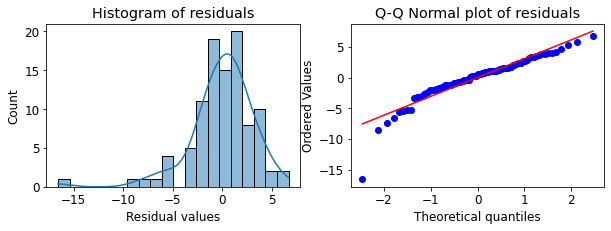

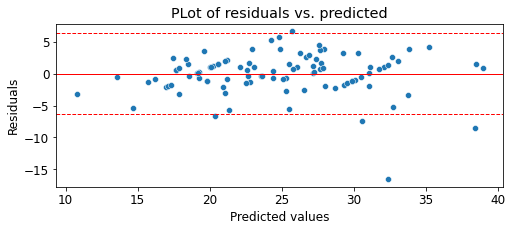

In [5]:
def residual_plot(df):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(8, 3), ) 
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df, ax=ax);
    plt.axhline(0.0, color='red', linewidth=1.0);
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0);
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0);
    plt.title('PLot of residuals vs. predicted');
    plt.xlabel('Predicted values');
    plt.ylabel('Residuals');
    plt.show()

def plot_resid_dist(df):
    resids = df.loc[:,'resids']
    plt.rc('font', size=12)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3));
    ## Plot a histogram
    sns.histplot(x=resids, bins=20, kde=True, ax=ax[0]);
    ax[0].set_title('Histogram of residuals');
    ax[0].set_xlabel('Residual values');
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1]);
    ax[1].set_title('Q-Q Normal plot of residuals');
    plt.show();    

def compute_residuals(df, model, label_col='city_mpg'):
    df['predicted'] = model.predict(df)
    df['resids'] = np.subtract(df.loc[:,'predicted'],df.loc[:,label_col]) 
    return df
    

auto_data_train = compute_residuals(auto_data_train, base_model)
plot_resid_dist(auto_data_train)
residual_plot(auto_data_train)

Overall these results are reasonably good. The distribution of the residuals is a bit skewed toward the negative. Further, the residuals are approximately homoskedastic. But otherwise the residuals appear Normally distributed and well behaved.    

The code in the cell below computes and prints some common evaluation metrics. In addition plots of the model fit are displayed. The calculations are performed on the test data subset. Execute the code below and examine the results.      

MSE  = 10.908
RMSE =  3.303
MAE  =  2.078


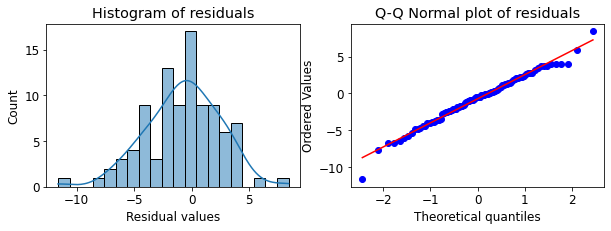

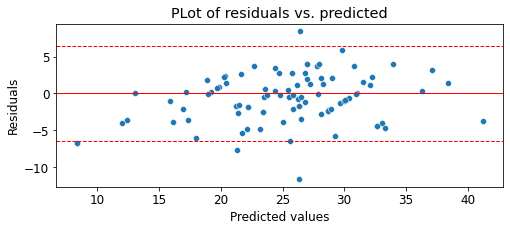

In [6]:
def compute_metrics(y_true, y_predicted):
    ## Compute the usual metrics
    mse = sklm.mean_squared_error(y_true, y_predicted)
    rmse = sqrt(mse)
    mae = sklm.median_absolute_error(y_true, y_predicted)
    return mse, rmse, mae

def print_metrics(df_test, model, label_col='city_mpg'): 
    df_test['predicted'] = model.predict(df_test)
    mse, rmse, mae = compute_metrics(df_test.loc[:,label_col],df_test.loc[:,'predicted'])   
    print('MSE  = {0:6.3f}'.format(mse))
    print('RMSE = {0:6.3f}'.format(rmse))
    print('MAE  = {0:6.3f}'.format(mae))

    
print_metrics(auto_data_test, base_model)   
auto_data_test = compute_residuals(auto_data_test, base_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)

We will use these metrics as a basis of comparison with regularized models.  

The distribution of the residuals show a bit of kurtosis (heavy trails), but are close to Normally distributed. Further, the residuals are approximately homoskedastic.  

> **Note:** No one regularization method works in all cases. In the running example you will see deviations from ideal behavior. Do not be surprised if not all methods improve the models. Further, do not generalize the behavior you observe in the exercises to other models. The effectiveness of regularization method is problem and model dependent.  

## Apply l2 regularization

Now, you will apply **l2 regularization** to constrains the model parameters. Constraining the model parameters prevent over-fitting of the model. This method is also known as **Ridge Regression**. 

But, how does this work? l2 regularization applies a **penalty** proportional to the **l2** or **Euclidean norm** of the model weights to the loss function. For linear regression using squared error as the metric, the total **loss function** is the sum of the squared error and the regularization term. The total loss function can then be written as follows:  

$$J(\beta) = ||A \beta + b||^2 + \alpha ||\beta||^2$$

Where the penalty term on the model coefficients, $\beta_i$, based on the Euclidean norm:

$$\alpha || \beta||^2 = \alpha \big(\beta_1^2 + \beta_2^2 + \ldots + \beta_n^2 \big)^{\frac{1}{2}} = \alpha \Big( \sum_{i=1}^n \beta_i^2 \Big)^{\frac{1}{2}}$$

We call $||\beta||^2$ the **l2 norm** of the coefficients, since we raise the weights of each coefficient to the power of 2, sum the squares and then raise the sum to the power of $\frac{1}{2}$. 

You can think of this penalty as constraining the 12 or Euclidean norm of the model weight vector. The value of $\alpha$ determines how much the norm of the coefficient vector constrains the solution. You can see a geometric interpretation of the l2 penalty constraint in the figure below.  

<img src="../images/L2.jpg" alt="Drawing" style="width:750px; height:400px"/>
<center>Geometric view of l2 regularization

Notice that for a constant value of the l2 norm, the values of the model parameters $B_1$ and $B_2$ are related. The Euclidean or l2 norm of the coefficients is shown as the dotted circle. The constant value of the l2 norm is a constant value of the penalty. Along this circle the coefficients change in relation to each other to maintain a constant l2 norm. For example, if $B_1$ is maximized then $B_2 \sim 0$, or vice versa. It is important to note that l2 regularization is a **soft constraint**. Coefficients are driven close to, but likely not exactly to, zero.    

### Review of Eigenvalue Decomposition

**Eigenvalues** are characteristic roots or characteristic values of a linear system of equations. The **eigenvalue-eigenvector** decomposition is a factorization of the a matrix. 

Let's start with a **square matrix**, $A$:

$$A = 
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}$$

Next define a vector, $x$: 

$$x = 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}$$

Then an **eigenvalue** of the matrix $A$ has the property: 

$$A x = \lambda x$$

Or,   

$$
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\lambda 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$



To see that the eigenvalue, $\lambda$, is a root of the matrix, $A$ we can rearrange the above as follows:   

\begin{align}
Ax - \lambda x &= 0 \\
(A - I \lambda) x &= 0
\end{align}

Where, $I$ is the **identity matrix** of 1 on the diagonal and 0 elsewhere. These relationships can be written as follows:  

$$
\begin{bmatrix}
   a_{11} - \lambda  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} - \lambda  & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn} - \lambda 
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$


The foregoing show that the eigenvalue, $\lambda$, is a root of the matrix, $A$. Further, notice that the eigin 

For an $n\ x\ n$ matrix, $A$, there are $n$ eigenvalues or roots. These can be found by solving the following equation, using the determinant:  

$$det(A - x) = 0$$

You can find more information on the determinant in this [article](https://en.wikipedia.org/wiki/Determinant).

### 2.1.3 Eigenvalues and the Normal Equations

Let's start by examining the **normal equation** formulation of the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used normal equation form can help with this problem:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is a symmetric $m x m$ covariance matrix, where $m$ is the number of model coefficients. This is a significant reduction in size when compared to $A$. 

Now, we can perform eigenvalue-eigenvector decomposition of $A^TA$:

$$A^TA = Q \Lambda Q^{-1}$$

Where,
$Q = $ unitary matrix of orthonormal **eigenvectors**, and
$\Lambda =$ diagonal matrix of **eigenvalues**. The eigenvalue matrix is diagonal:  

$$\Lambda = 
\begin{bmatrix}
    \lambda_1  & 0 & 0 & \dots & 0 \\
    0  & \lambda_2 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \lambda_n
\end{bmatrix}$$


Since Q is unitary (unit norm), the inverse of $A^TA$ is easily computed:

$$(A^TA)^{-1} = Q \Lambda^{-1} Q^{-1}$$

Where,
$$\Lambda^{-1} = 
\begin{bmatrix}
    \frac{1}{\lambda_1}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_n}
\end{bmatrix}$$
and $\lambda_i$ is the ith eigenvalue. 

But, **$A^TA$ can still be rank deficient!** By rank deficient we mean that there are fewer non-zero eigenvalues of $A^TA$ than the dimension, $n$. Even is the ith eigenvalue is close to zero, $\frac{1}{\lambda_i}$ becomes very large and destabilizes the inverse. 

The basic idea of $l_2$ regularization, Tikhonov regularization, or ridge regression is to stabilize the inverse eigenvalue matrix,$\Lambda$, by **adding a small bias term**, $\alpha$, to each of the eigenvalues. We can write this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \alpha^2 \cdot I \parallel]\\  or \\
b = (A^TA + \alpha^2 \cdot I)^{-1}A^Tx$$

In this way, the inverse values of small eigenvalues do not blow up when we compute the inverse. You can see this by writing out the $\Lambda^+$ matrix with the bias term.

$$\Lambda_{Tikhonov}^+  = \begin{bmatrix}
    \frac{1}{\lambda_1 + \alpha^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2 + \alpha^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_m + \alpha^2}
\end{bmatrix}$$

Adding this bias term ensures there are no non-zero eigenvalues, and that the inverse of $A^TA$ exists. You can also see that added the bias term adds a 'ridge' along the diagonal of the eigenvalue matrix, giving this method one of its names. 

### The Bayesian Interpretation

Another way to view l2 regularization is using a Bayesian formulation of the problem. Let's start with the posterior distribution of the weight vector $W$ given the features $X$ and labels $Y$. Using Bayes rule we can write this posterior distribution as:

$$p( W\ |\ \{X,Y\} ) = \frac{p(W)\ p(\{X,Y\}\  |\  W\ )}{p( \{X,Y\})}$$

where,

$p(W) = $ the prior distribution of $W$.   
$p(\{X,Y\}\  |\  W\ ) = $ the likelihood of $\{X,Y\}$ given $W$.

We want the **maximum a posteriori** or **MAP** of the weights, $W$. Taking the log of both sides:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) \propto max_W\ \Big[ log \big( p(W) \big)\  + log \big( p(\{X,Y\}\  |\  W\ ) \big) \Big]\\
= max_W \Big[ log\big(prior(W)\big) + log \big( likelihood(\{X,Y\}\  |\  W\ ) \big) \Big]$$

For a Gaussian process with l2 loss and l2 regularization we formulate the problem:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) = max_W \Big[\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 + \lambda || W ||^2 \big) \Big]$$  

where,   
$\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 = $ the likelihood.    
$\lambda || W ||^2 = $ the prior acting as a regularization penalty. 


So how are we to interpret this prior? It is useful to view the prior as constraining the norm of the weight vector close to zero. In other words, we think of the weights as **shrinking** toward zero. Thus, the shrinkage process prevents the weights from reaching extreme values. 

### An example    

How can we use the eigenvalue decomposition of the covariance matrix to better understand how stable a linear model is? One way to summarize stability is to compute the **condition number**, which is the ratio of the largest to the smallest eigenvalue:   

$$condition\ number = \frac{largest\ eigenvalue}{smallest\ eigenvalue}$$   

A linear model with a covariance matrix having a large condition number is unstable and the model coefficients will be poorly determined. In other words, when the condition number is large, we can expect high variance and poor generalization. As a rule of thumb, the condition number of a **well-posed** linear model should be less than about 100. Otherwise, we say the model is **ill-posed**.    

> **Exercise 25-1:**  You will now compute the compute the covariance matrix for the model specified above and evaluate its eigenvalues.     
> 1. Construct the design (model) matrix using the training data subset. You can do this with the [patsy.dematrix](https://patsy.readthedocs.io/en/latest/API-reference.html) function.      
> 2. Use [numpy.transpose](https://numpy.org/devdocs/reference/generated/numpy.transpose.html) and [numpy.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) functions to compute the covariance matrix of the design matrix. Make sure you normalize by dividing by the dimension of the covariance matrix!     
> 3. Compute the [numpy.linalg.eigvals](https://numpy.org/devdocs/reference/generated/numpy.linalg.eigvals.html) function to compute the eigenvalues. Save the real part of these complex numbers using [numpy.real](https://numpy.org/devdocs/reference/generated/numpy.real.html) and print the result.   
> 4. Compute and print the condition number.   

In [7]:
Y, X = dmatrices(formula, data=auto_data_train)
cov_X = np.matmul(np.transpose(X),X)
cov_X = np.divide(cov_X, float(cov_X.shape[0]))
eigenvalues = np.real(np.linalg.eigvals(cov_X))
print(eigenvalues)
print('\nThe condition number = {0:6.1f}'.format(eigenvalues[0]/eigenvalues[-1]))

[2.14840237e+01 3.33546605e+00 2.25403970e+00 1.45310274e+00
 1.20221710e+00 9.09383576e-01 6.05256678e-01 3.32421561e-01
 3.14073612e-01 2.61640746e-01 1.17203833e-01 7.68668205e-02
 3.84893859e-02 3.37096798e-02 1.09445900e-02 3.38080732e-05]

The condition number = 635470.2


> What does this condition number tell you about the stability of the coefficient estimates for this model? Is this consistent with what you learned from the model summary?   
> **End of Exercise.**

### Example of ridge regression   

When L2 regularization is applied to regression the resulting algorithm is often referred to as **ridge regression**. For this algorithm, the regularization parameter, $\alpha$, must be selected. For a given problem, there is are limited theory-based options to find the best value of $\alpha$, Therefore, one typically resorts to a **hyperparameter** search. 

There are several possible approaches to hyperparameter search. An error metric, such as MSE or MAE is used to determine the optimal value.    

The simplest approach is to search of grid (or line) of regularly spaced hyperparameter values. At each gird point the model performance metric is computed. The best model is considered the one with the best metric. We will use this simpler approach here.       

An alternative is to randomly sample the space of hyperparameter values. This later approach is more efficient.     

> **Exercise 25-2:** You will now perform a search to find a best regularization hyperparameter by the following steps:      
> 1. Complete the code in the `regularized_coefs` function to compute a regularized OLS model using the value of alpha and L1_wt. For each value of alpha searched, this model will be computed and evaluated.      
> 2. In the space provided below the functions create an array of alpha values from 0.0 to 0.005 in steps of 0.00005.  
> 3. Execute the code and examine the results.  

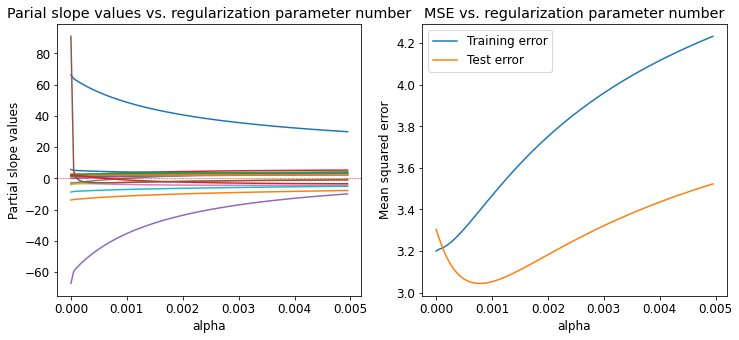

In [8]:
def regularized_coefs(df_train, df_test, alphas, L1_wt=0.0, n_coefs=15,
                      formula = formula, label='city_mpg'):
    '''Function that computes a linear model for each value of the regualarization 
    parameter alpha and returns an array of the coefficient values. The L1_wt 
    determines the trade-off between L1 and L2 regualarization'''
    coefs = np.zeros((len(alphas),n_coefs + 1))
    MSE_train = []
    MSE_test = []
    for i,alpha in enumerate(alphas):
        ## First compute the training MSE
        temp_mod = smf.ols(formula, data=df_train).fit_regularized(alpha=alpha,L1_wt=L1_wt)
        coefs[i,:] = temp_mod.params
        MSE_train.append(sqrt(np.mean(np.square(df_train[label] - temp_mod.predict(df_train)))))
        ## Then compute the test MSE
        MSE_test.append(sqrt(np.mean(np.square(df_test[label] - temp_mod.predict(df_test)))))
        
    return coefs, MSE_train, MSE_test


def plot_coefs(coefs, alphas, MSE_train, MSE_test, ylim=None):
    fig, ax = plt.subplots(1,2, figsize=(12, 5)) # define axis
    for i in range(coefs.shape[1]): # Iterate over coefficients
        ax[0].plot(alphas, coefs[:,i])
    ax[0].axhline(0.0, color='red', linestyle='--', linewidth=0.5)
    ax[0].set_ylabel('Partial slope values')
    ax[0].set_xlabel('alpha')
    ax[0].set_title('Parial slope values vs. regularization parameter number')
    if ylim is not None: ax[0].set_ylim(ylim)
    
    ax[1].plot(alphas, MSE_train, label='Training error')
    ax[1].plot(alphas, MSE_test, label='Test error')
    ax[1].set_ylabel('Mean squared error')
    ax[1].set_xlabel('alpha')
    ax[1].set_title('MSE vs. regularization parameter number')
    plt.legend()
    plt.show()
    
alphas = np.arange(0.0, 0.005, step = 0.00005)
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas)

plot_coefs(Betas, alphas, MSE_train, MSE_test) #, ylim=[-10,10])

> Examine these plots. Notice how the training error increases and the model coefficients decrease in value with increasing regularization hyperparameter. This is expected, since as the coefficient values of the model are forced toward 0, the training bias increases. Notice however, the behavior of the MSE for the test data. Approximately at which value is the test MSE minimized?             
> **End of exercise.**    

> **Exercise 25-3:** Now you will evaluate the L2 regularized model using the optimal value of $\alpha$ you estimated from the graph of training MSE in Exercise 25-2.      
> 1. Compute a regularized OLS model using the training data and your estimate of the optimal value of $\alpha$ and `L1_wt=0.0`.     
> 2. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 3. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.  

MSE  =  9.266
RMSE =  3.044
MAE  =  2.141


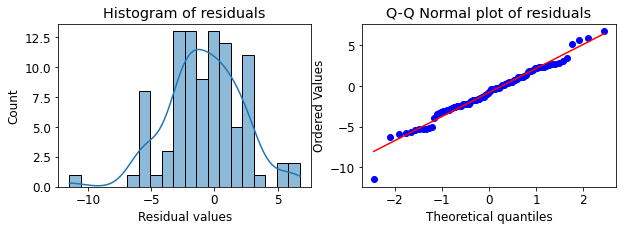

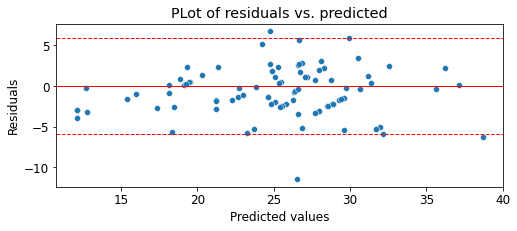

In [9]:
L2_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.0008, L1_wt=0.0)

print_metrics(auto_data_test, L2_model)   
auto_data_test = compute_residuals(auto_data_test, L2_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)

> Examine these results and answer these questions.   
> 1. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse? Keeping in mind that the model is the product of a least squares fit, do the results make sense?   
> 2. How does the distribution of the residuals compare to those of the unregularized models in terms of changes of skewness and the outlier?
> 3. Do the residuals still appear approximately homoskedastic? 
> **End of exercise.**  

> **Exercise 25-4:** You will now compare the condition number of the regularized covariance matrix to the unregularized covariance matrix you computed earlier.     
> 1. Add a matrix with the value of the square root of the optimal $alpha$ value estimated along the diagonal (0 elsewhere) to the covariance matrix you computed in Exercise 25-2. Use [numpy.diag]() to instantiate the diagonal matrix.    
> 2. Compute and display the eigenvalues of the regularized covariance matrix.  
> 3. Compute and display the condition number of the regularized covariance matrix. 

In [10]:
cov_X = cov_X + np.diag([sqrt(0.0008)]*cov_X.shape[0])
eigenvalues = np.real(np.linalg.eigvals(cov_X))
print(eigenvalues)
print('\nThe condition number = {0:6.2f}'.format(eigenvalues[0]/eigenvalues[-1]))

[21.51230796  3.36375033  2.28232397  1.48138701  1.23050137  0.93766785
  0.63354095  0.36070583  0.34235788  0.28992502  0.1454881   0.10515109
  0.06677366  0.06199395  0.03922886  0.02831808]

The condition number = 759.67


> Compare the condition numbers you have computed for the regularized and unregularized condition number. Has regularization made a significant difference? Does the regularized model still appear to have an undesirably large condition number?  
> **End of exercise.**

## Apply l1 regularizaton

Regularization can be performed using norms other than l2. The **l1 regularizaton** or **Lasso**  method limits the sum of the absolute values of the model coefficients. The l1 norm is sometime know as the **Manhattan norm**, since distance are measured as if you were traveling on a rectangular grid of streets. This is in contrast to the l2 norm that measures distance 'as the crow flies'. 

We can compute the l1 norm of the model coefficients as follows:

$$||\beta||^1 = \big( |\beta_1| + |\beta_2| + \ldots + |\beta_n| \big) = \Big( \sum_{i=1}^n |\beta_i| \Big)^1$$

where $|\beta_i|$ is the absolute value of $\beta_i$. 

Notice that to compute the l1 norm, we raise the sum of the absolute values to the first power.

As with l2 regularization, for l1 regularization, a penalty term is multiplied by the l1 norm of the model coefficients. A penalty multiplier, $\lambda$, determines how much the norm of the coefficient vector constrains values of the weights. The complete loss function is the sum of the squared errors plus the penalty term which becomes: 

$$J(\beta) = ||A \beta + b||^2 + \lambda ||\beta||^1$$

You can see a geometric interpretation of the l1 norm penalty in the figure below.  

<img src="../images/L1.jpg" alt="Drawing" style="width:700px; height:400px"/>
<center> Geometric view of L1 regularization

The l1 norm is constrained by the sum of the absolute values of the coefficients. This fact means that values of one parameter highly constrain another parameter. The dotted line in the figure above looks as though someone has pulled a rope or lasso around pegs on the axes. This behavior leads the name lasso for l1 regularization.  

Notice that in the figure above that if $B_1 = 0$ then $B_2$ has a value at the limit, or vice versa. In other words, using a l1 norm constraint forces some weight values to zero to allow other coefficients to take non-zero values. Thus, you can think of the l1 norm constraint **knocking out** some weights free the model altogether. In contrast to l2 regularization, l1 regularization does drive some coefficients to exactly zero.

> **Exercise 25-5:** Continuing with the running example you will now apply L1 regularization to the model.    
> 1. Create an array with values of $\alpha$ from 0.0 to 0.05 in steps of 0.00005.   
> 2. Using the hyperparameter search function you created for exercise 25-2 compute the model performance metrics for each value of $\alpha$ and with `L1_wt` set to 1.0; all weight on L1 regularization.     

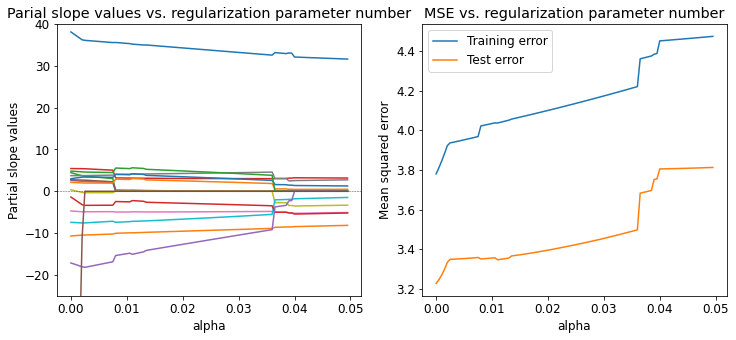

In [11]:
alphas = np.arange(0.0, 0.05, step = 0.0005)
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas, L1_wt=1.0)

plot_coefs(Betas, alphas, MSE_train, MSE_test, ylim=[-25,40])

> The curve of training error does not have a well defined minimum, except at $\alpha = 0$. Is there any well defined minimum for the test error? Based on this behavior, do you expect that L1 regularization to improve model generalization?      
> **End of exercise.**

> **Exercise 25-6:** Now you will evaluate the L1 regularized model using the optimal a value $\alpha$ where there is a small dig in the test error curve.      
> 1. Compute a regularized OLS model using the training data and your estimate of the optimal value of $\alpha = 0.012$ and `L1_wt=1.0`.     
> 2. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 3. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.   
> 4. Print the model coefficients. These coefficients are the `params` attribute of the model object.   

MSE  = 11.229
RMSE =  3.351
MAE  =  1.918


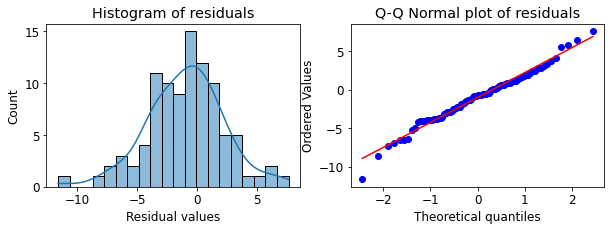

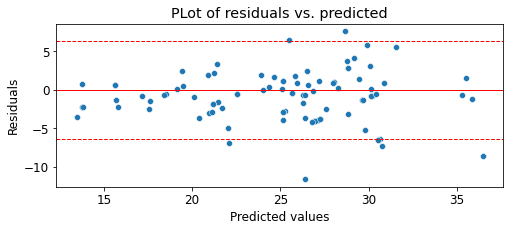

Intercept                     35.081129
C(fuel_type)[T.gas]           -9.893172
C(body_style)[T.hardtop]       0.000000
C(body_style)[T.hatchback]     3.133239
C(body_style)[T.sedan]         0.000000
C(body_style)[T.wagon]         0.223374
C(aspiration)[T.turbo]        -4.923301
C(drive_wheels)[T.fwd]         4.107371
C(drive_wheels)[T.rwd]         0.000000
C(engine_location)[T.rear]    -7.153618
C(engine_type)[T.l]            4.108259
C(engine_type)[T.ohc]          2.979002
C(engine_type)[T.ohcf]         5.539169
C(engine_type)[T.ohcv]        -2.316711
curb_weight                  -14.777833
engine_size                    0.000000
dtype: float64

In [12]:
L1_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.012,L1_wt=1.0)

print_metrics(auto_data_test, L1_model)   
auto_data_test = compute_residuals(auto_data_test, L1_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)
L1_model.params

> Examine these results and answer these questions.   
> 1. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse? 
> 2. How does the distribution of the residuals compare to those of the unregularized models in terms of changes of skewness, kurtosis and the outlier?
> 3. Do the residuals still appear approximately homoskedastic?    
> 4. Examine the model coefficients, noticing that some are 0.0 as expected with L1 regularization. What does this tell you about the usefulness of some of the model features, particularly the numeric features?    
> **End of exercise.**  

## Elastic Net Regularization    

We have now examined a bit of theory and examples of L2 and L1 regularization. We can compare the characteristics of these methods as follows:  

- L2 regularization works well for **colinear features**    
   - Down-weights colinear features   
   - But soft constraint so poor model selection 

- L1 regularization provides **good model selection** by hard constraint    
   - But poor selection for colinear features     

But, we do not always have to choose between soft constraint of L2 and hard constraint of L1. The **elastic net regularization** combines the behavior of both methods. The loss function for elastic net is expressed:         

$$min \Big[ \parallel A \cdot x - b \parallel +\ \lambda\ \alpha \parallel b\parallel^1 +\ (1- \lambda)\ \alpha \parallel b\parallel^2 \Big]$$     

This model has two hyperparameters:    
- $\lambda$ weights L1 vs. L2 regularization.      
- $\alpha$ sets strength of regularization.   

Tuning this model, requires a 2-dimensional hyperparameter search. This search can be done on a grid or by random sampling, as was discussed previously.           

> **Exercise 25-7:**  Continuing with the running example you will now apply elastic net regularization to the model.    
> 1. Create an array with values of $\alpha$ from 0.0 to 0.05 in steps of 0.00005.   
> 2. Using the hyperparameter search function you created for exercise 25-2 compute the model performance metrics for each value of $\alpha$ and with `L1_wt` set to 0.5. In this case, we equal weight L2 and L1 regularization in order to simplify the hyperparameter search. Performance could possibly improved if a 2-hyperparameter search was performed.     

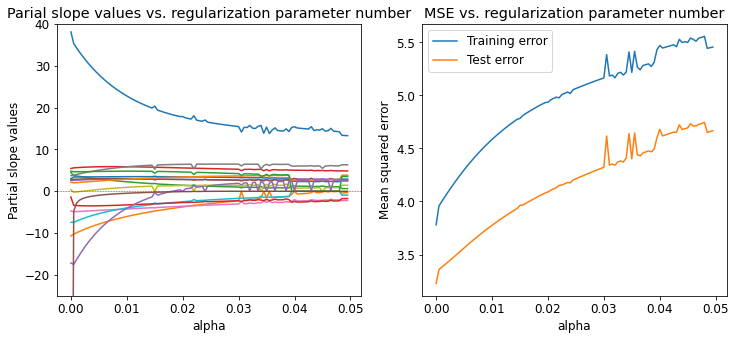

In [13]:
alphas = np.arange(0.0, 0.05, step = 0.0005)
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas, L1_wt=0.1)

plot_coefs(Betas, alphas, MSE_train, MSE_test, ylim=[-25,40])

> One again, the curve of training error does not have a well defined minimum, except at $\alpha = 0$. Is there any well defined minimum for the test error? Based on this behavior, do you expect that elastic net regularization to improve model generalization?      
> **End of exercise.**

> **Exercise 25-8:** Now you will evaluate the elastic net regularized model using an arbitrary value of $\alpha$.      
> 1. Compute a regularized OLS model using the training data and your estimate of the optimal value of $\alpha = 0.012$ and `L1_wt=0.5`, putting equal weight on L2 and L1.     
> 2. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 3. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.   
> 4. Print the model coefficients. These coefficients are the `params` attribute of the model object.   

MSE  = 11.271
RMSE =  3.357
MAE  =  1.988


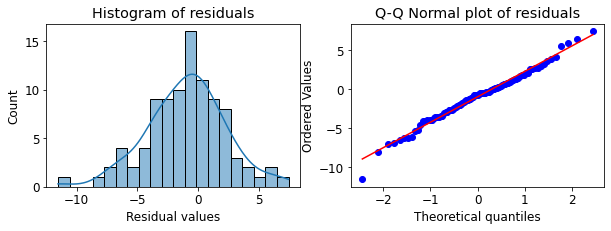

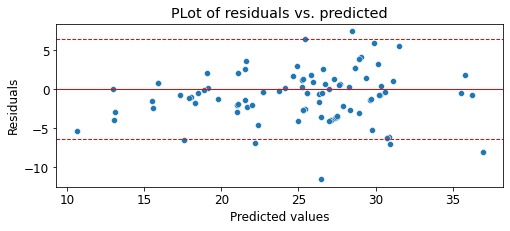

Intercept                     35.408337
C(fuel_type)[T.gas]          -10.267800
C(body_style)[T.hardtop]       3.764324
C(body_style)[T.hatchback]     5.566818
C(body_style)[T.sedan]         2.547059
C(body_style)[T.wagon]         2.838513
C(aspiration)[T.turbo]        -4.887908
C(drive_wheels)[T.fwd]         3.846993
C(drive_wheels)[T.rwd]        -0.248338
C(engine_location)[T.rear]    -7.438624
C(engine_type)[T.l]            3.418311
C(engine_type)[T.ohc]          2.017114
C(engine_type)[T.ohcf]         4.656176
C(engine_type)[T.ohcv]        -3.356936
curb_weight                  -17.555071
engine_size                   -4.442927
dtype: float64

In [14]:
elastic_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.0012, L1_wt=0.5)

print_metrics(auto_data_test, elastic_model)   
auto_data_test = compute_residuals(auto_data_test, elastic_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)
elastic_model.params

> Examine these results and answer these questions.   
> 1. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse? 
> 2. Do the residuals still appear approximately homoskedastic?    
> 3. Examine the model coefficients? Are any of the coefficients 0? Is this behavior expected from the soft constraint of L2 regularization or the hard constraint of L1 regularization.        
> **End of exercise.**  

## Summary

In this lab you have explored the basics of regularization. Regularization can prevent machine learning models from being overfit. Regularization is required to help machine learning models generalize when placed in production. Selection of regularization strength involves consideration of the bias-variance trade-off. 

L2 and l1 regularization constrain model coefficients to prevent overfitting. L2 regularization constrains model coefficients using a Euclidian norm. L2 regularization can drive some coefficients toward zero, usually not to zero. On the other hand, l1 regularization can drive model coefficients to zero.    

The elastic net algorithm provides weighted behavior between the L1 and L2 methods. 

#### Copyright 2017, 2018, 2019, 2020, 2021 Stephen F Elston. All rights reserved. 